<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp/blob/main/TP_microestados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

# 1. Instalacion de paquetes

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [3]:
if is_runing_into_colab_env():
    !pip install mne

# 2. Descargar dataset

Se descarga el dataset y lo descomprime en `~/dataset`.

In [4]:
filename     = "procesados-20210908T224817Z-001.zip"
dataset_url  =  f'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/{filename}'
dataset_path = "dataset"

if is_runing_into_colab_env():
    !cd ~
    !rm -rf procesados
    !rm -rf dataset
    !rm -rf {filename}
    !wget  {dataset_url}
    !unzip {filename}
    !mv procesados dataset
    !apt install -y tree
    clear_output()
    !tree dataset

# 3. Importa libreria del proyecto

In [5]:
if is_runing_into_colab_env():
    if path.exists('/content/dm-cyt-tp'):
        print('Pull...\n')
        !cd dm-cyt-tp; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp.git

In [6]:
sys.path.append('/content/dm-cyt-tp/src' if is_runing_into_colab_env() else './src')

# 4. Importa paquetes externos

In [7]:
import numpy as np
import pandas as pd

from scipy.signal import find_peaks

from sklearn.cluster          import KMeans, DBSCAN   #opcion kmeans y dbscan definir cuales se usan
from sklearn.metrics          import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy  import dendrogram, linkage, cophenet, fcluster
from sklearn.preprocessing    import MinMaxScaler

from plot import plot_gfp, \
                 plot_silhoutte_modificado2, \
                 plot_eeg_pca, \
                 plot_eeg_topology_on_axis, \
                 plot_egg_on_axis, \
                 plot_eegs_summary, \
                 plot_sx_reduce_noise, \
                 plot_maps_pca, \
                 plot_vectores_kmeans, \
                 plot_silhoutte, \
                 plot_dendrogram, \
                 plot_distancia_euclidea

from gfp  import find_gfp_peaks, \
                 show_complete_gfp_peaks_summary, \
                 reduce_noise_pca

from eeg  import get_info_eeg_and_montage, \
                 eegs_total_mean, \
                 order_asc_by_subject, \
                 order_asc_by_resting_state

from gev        import calculo_gev

from clustering import van_dongen, \
                       kmeans2, \
                       silhoutte_modificado2

from read_eeg  import load_eeg_dataset
from util      import concat_fields, data_field
import mne

El registro de EEG de 30 canales viene en formato txt (cada uno de los canales es una señal de un electrodo). La frecuencia de muestreo de la señal orginal es de 256 Hz, luego fue filtrada y resampleada a 128 Hz.

## 5. Lectura de EEG's

Para cada persona identificada con el número que sigue a "suj_" se hicieron dos registros para cada persona, uno antes de aprender algo "bl_1" y el otro despues de aprender algo "bl_2"

In [8]:
eegs = load_eeg_dataset('./dataset/*')

In [9]:
eegs[1].to_dict()

{'subject': '9',
 'resting_state': '2',
 'nchannels': 30,
 'sfrequency': 128,
 'nsamples': 7681,
 'data': array([[ 6.4596 ,  2.4325 ,  1.7316 , ...,  0.63108, -9.7919 ,  1.8854 ],
        [ 1.7245 , -0.73154, -0.13338, ..., -2.9122 , -3.1555 , -1.8625 ],
        [-2.7028 , -3.5587 , -1.8376 , ..., -6.1657 ,  4.1212 , -5.3844 ],
        ...,
        [-1.4558 , -1.7363 , -6.3833 , ..., -2.8764 ,  3.1372 , -4.9186 ],
        [-1.5864 , -1.5054 , -2.7014 , ..., -2.6479 ,  4.8606 , -5.1937 ],
        [-0.03244, -0.37213,  2.3855 , ..., -2.2923 ,  4.4682 , -4.7686 ]])}

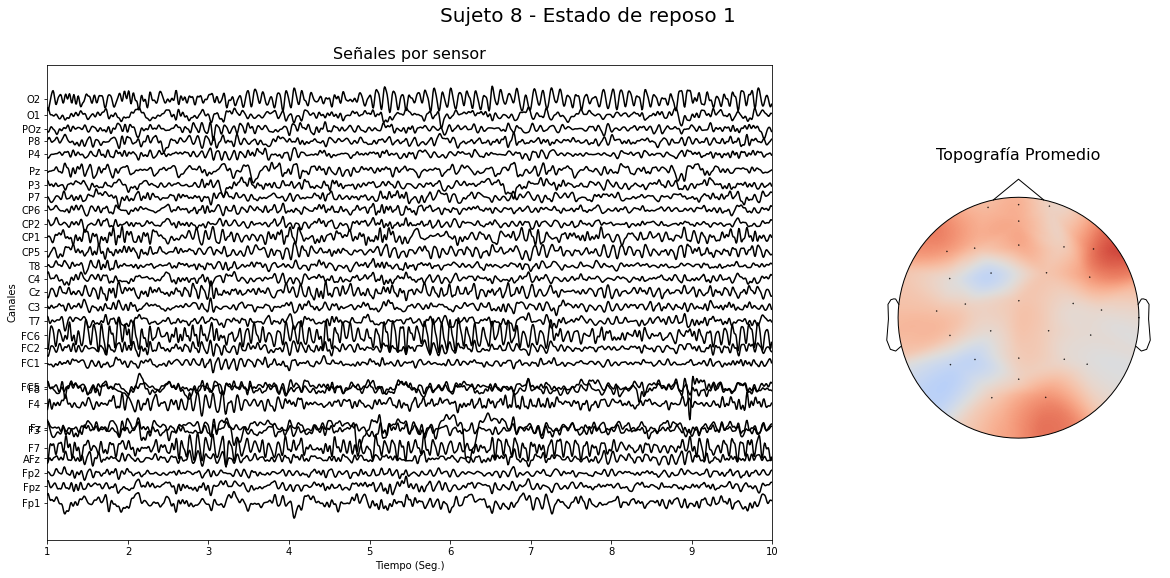

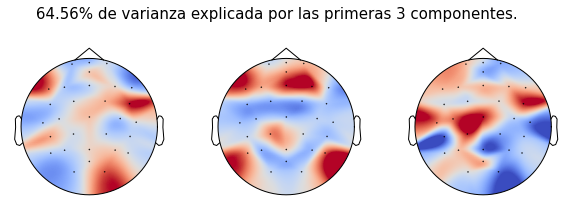

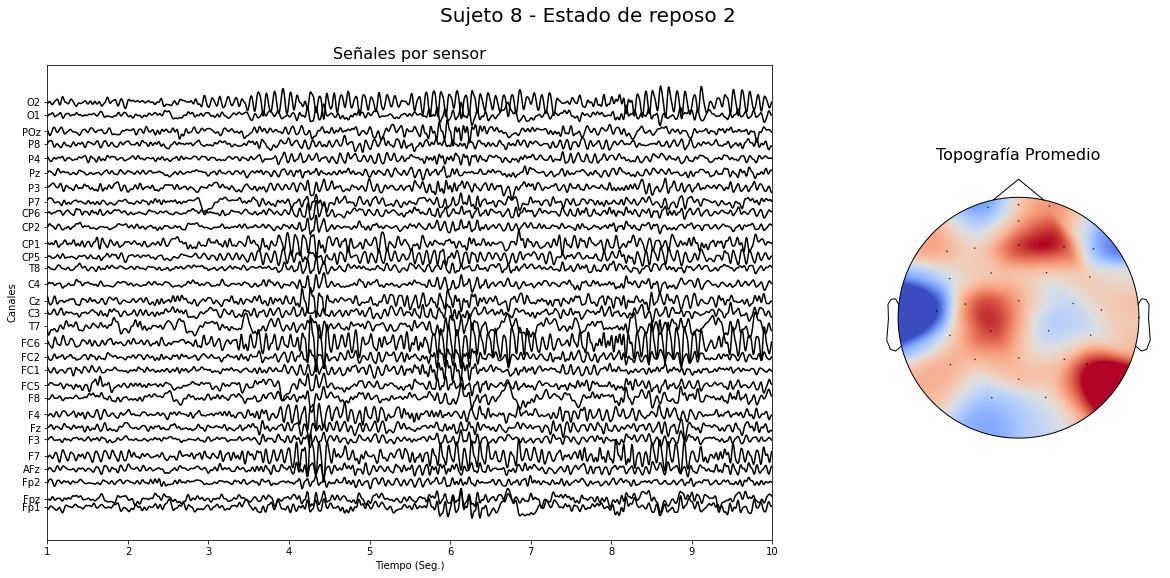

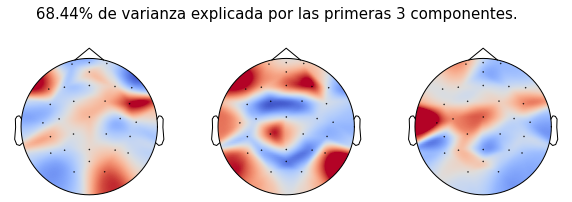

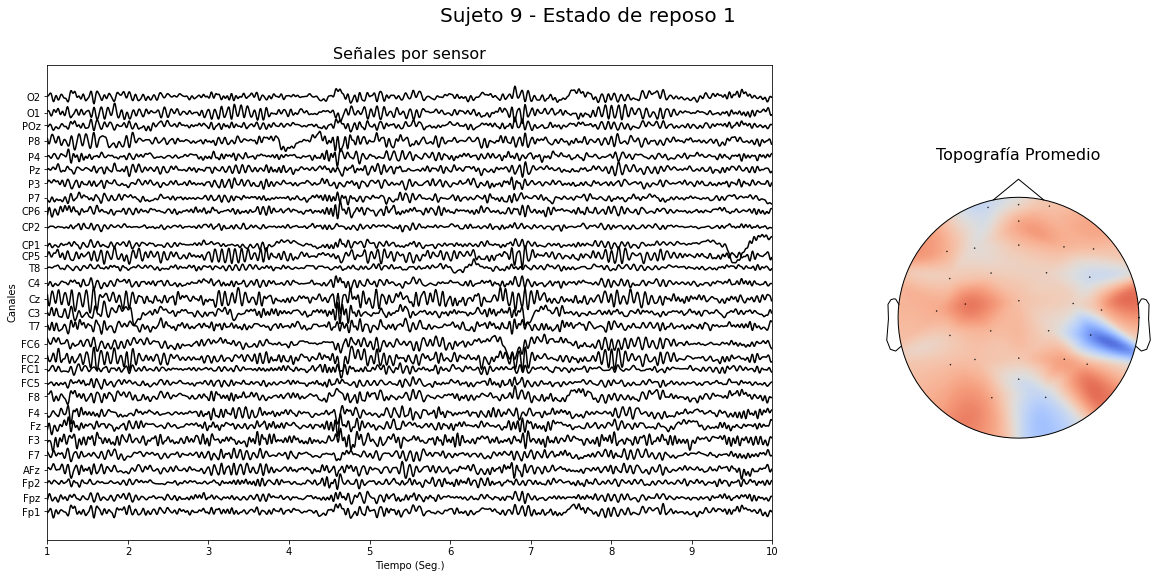

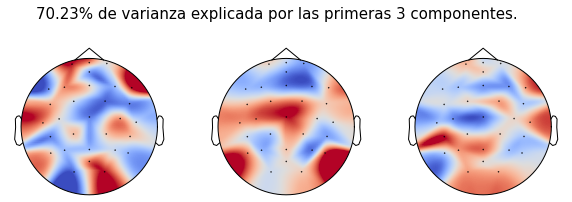

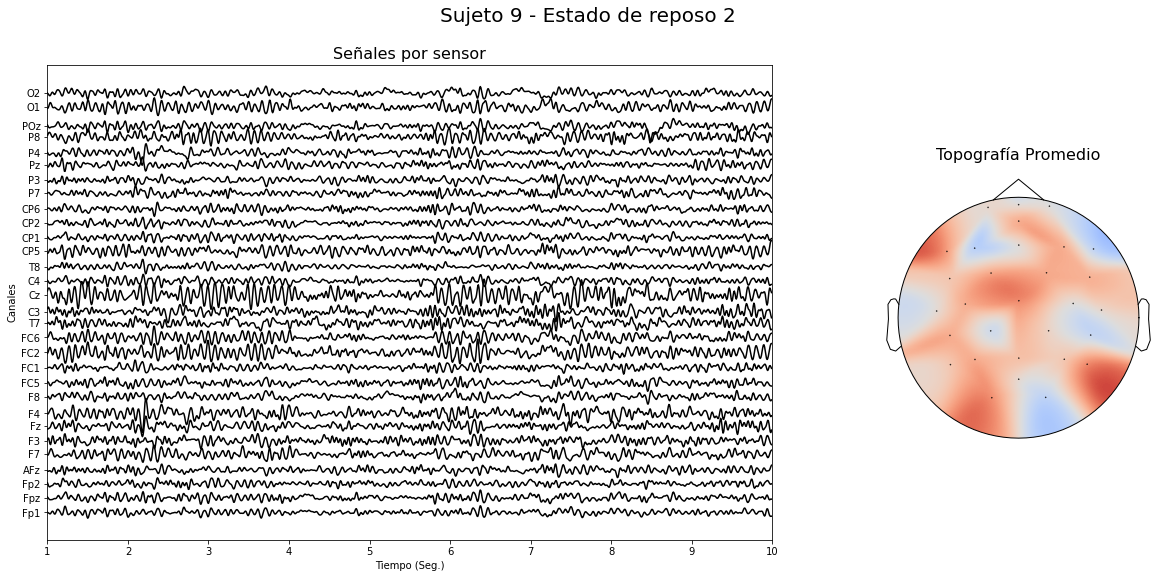

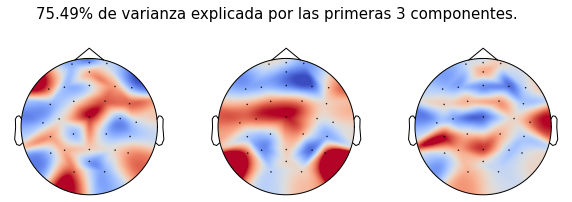

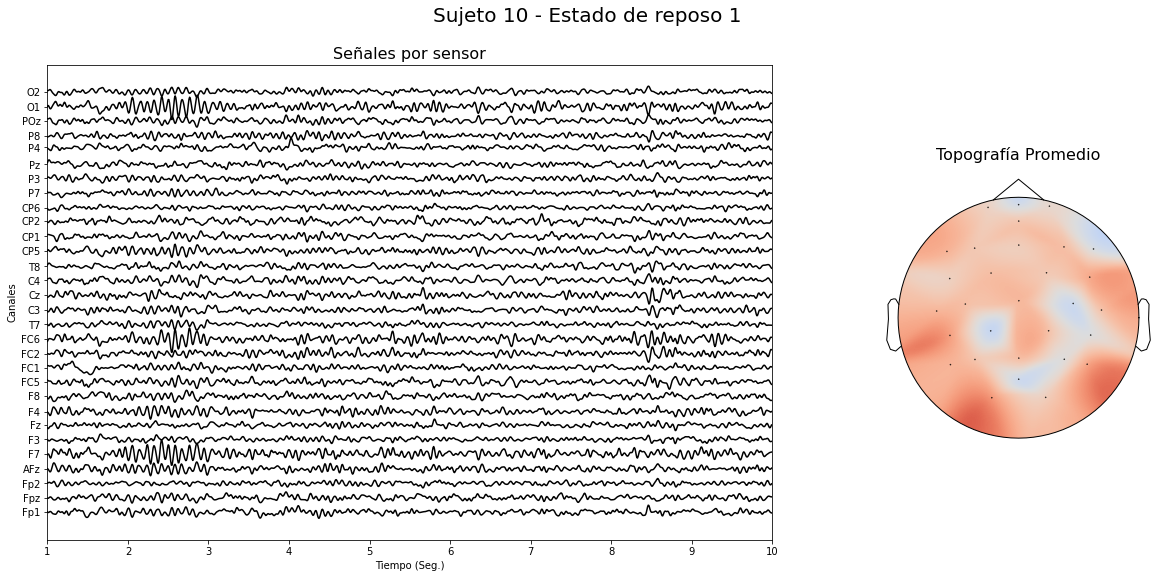

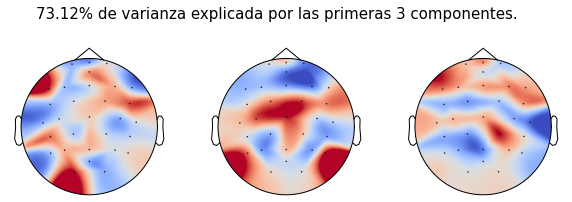

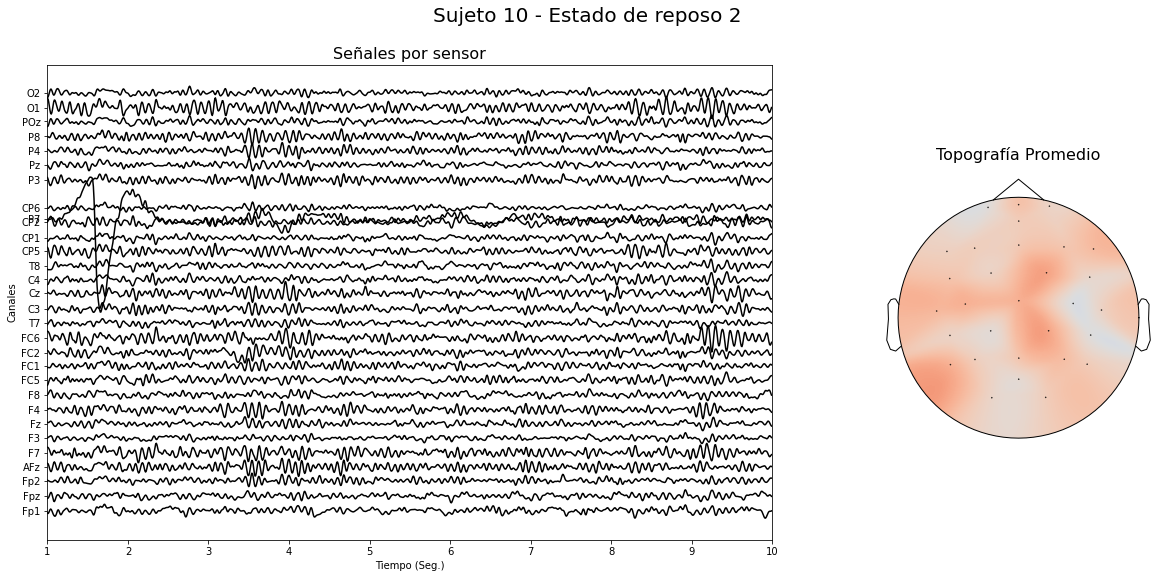

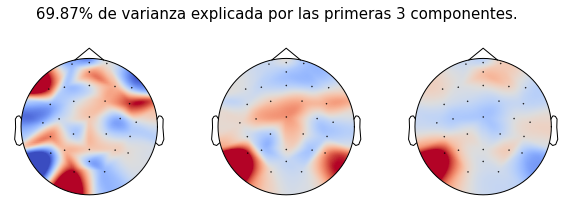

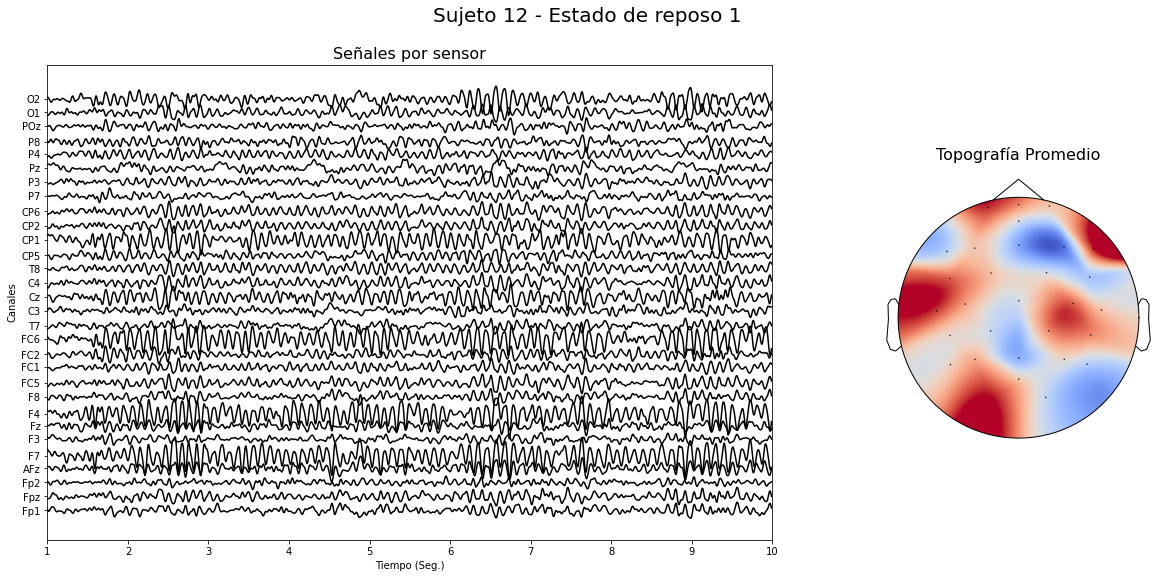

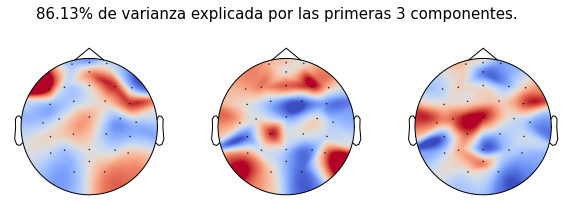

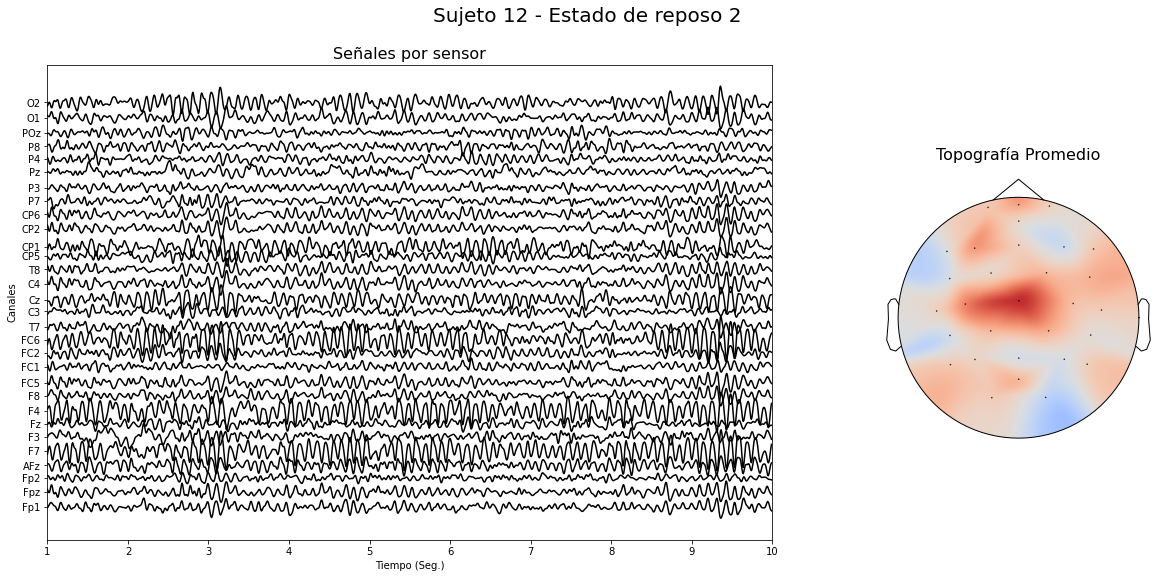

In [10]:
info_eeg, montage = get_info_eeg_and_montage()

plot_eegs_summary(eegs, info_eeg, montage)

In [11]:
promedios_totales = eegs_total_mean(eegs)

print(promedios_totales.max(axis=None))
print(promedios_totales.min(axis=None))

0.01997477326822899
-0.02942990907942702


Todos los promedios dan cercanos a 0 porque los datos procesados tienen filtrada las bajas frecuencias. 

In [12]:
print(promedios_totales.max(axis=1))
print(promedios_totales.min(axis=1))

[0.01100957 0.0092637  0.01961749 0.00627234 0.01815815 0.01997477
 0.01143988 0.01742602 0.00538763 0.00713698]
[-0.02093899 -0.01089066 -0.02586782 -0.00552607 -0.00970843 -0.00530727
 -0.00937769 -0.02942991 -0.00441476 -0.00891953]


In [13]:
eegs_subject=order_asc_by_subject(eegs)
eegs_resting_state=order_asc_by_resting_state(eegs)

Análisis de componentes principales - distinguiendo por resting_state -  resting_state=1

In [14]:
plot_eeg_pca(info_eeg, np.transpose(concat_fields(eegs_resting_state[0:5], data_field)))

Análisis de componentes principales - distinguiendo por resting_state -  resting_state=2

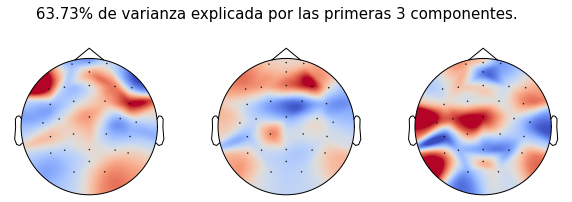

In [15]:
plot_eeg_pca(info_eeg, np.transpose(concat_fields(eegs_resting_state[5:], data_field)))

Los registros fueron tomados con el montage 10-20.
Tengo que armarlo que los electrodos tengan esta distribución:
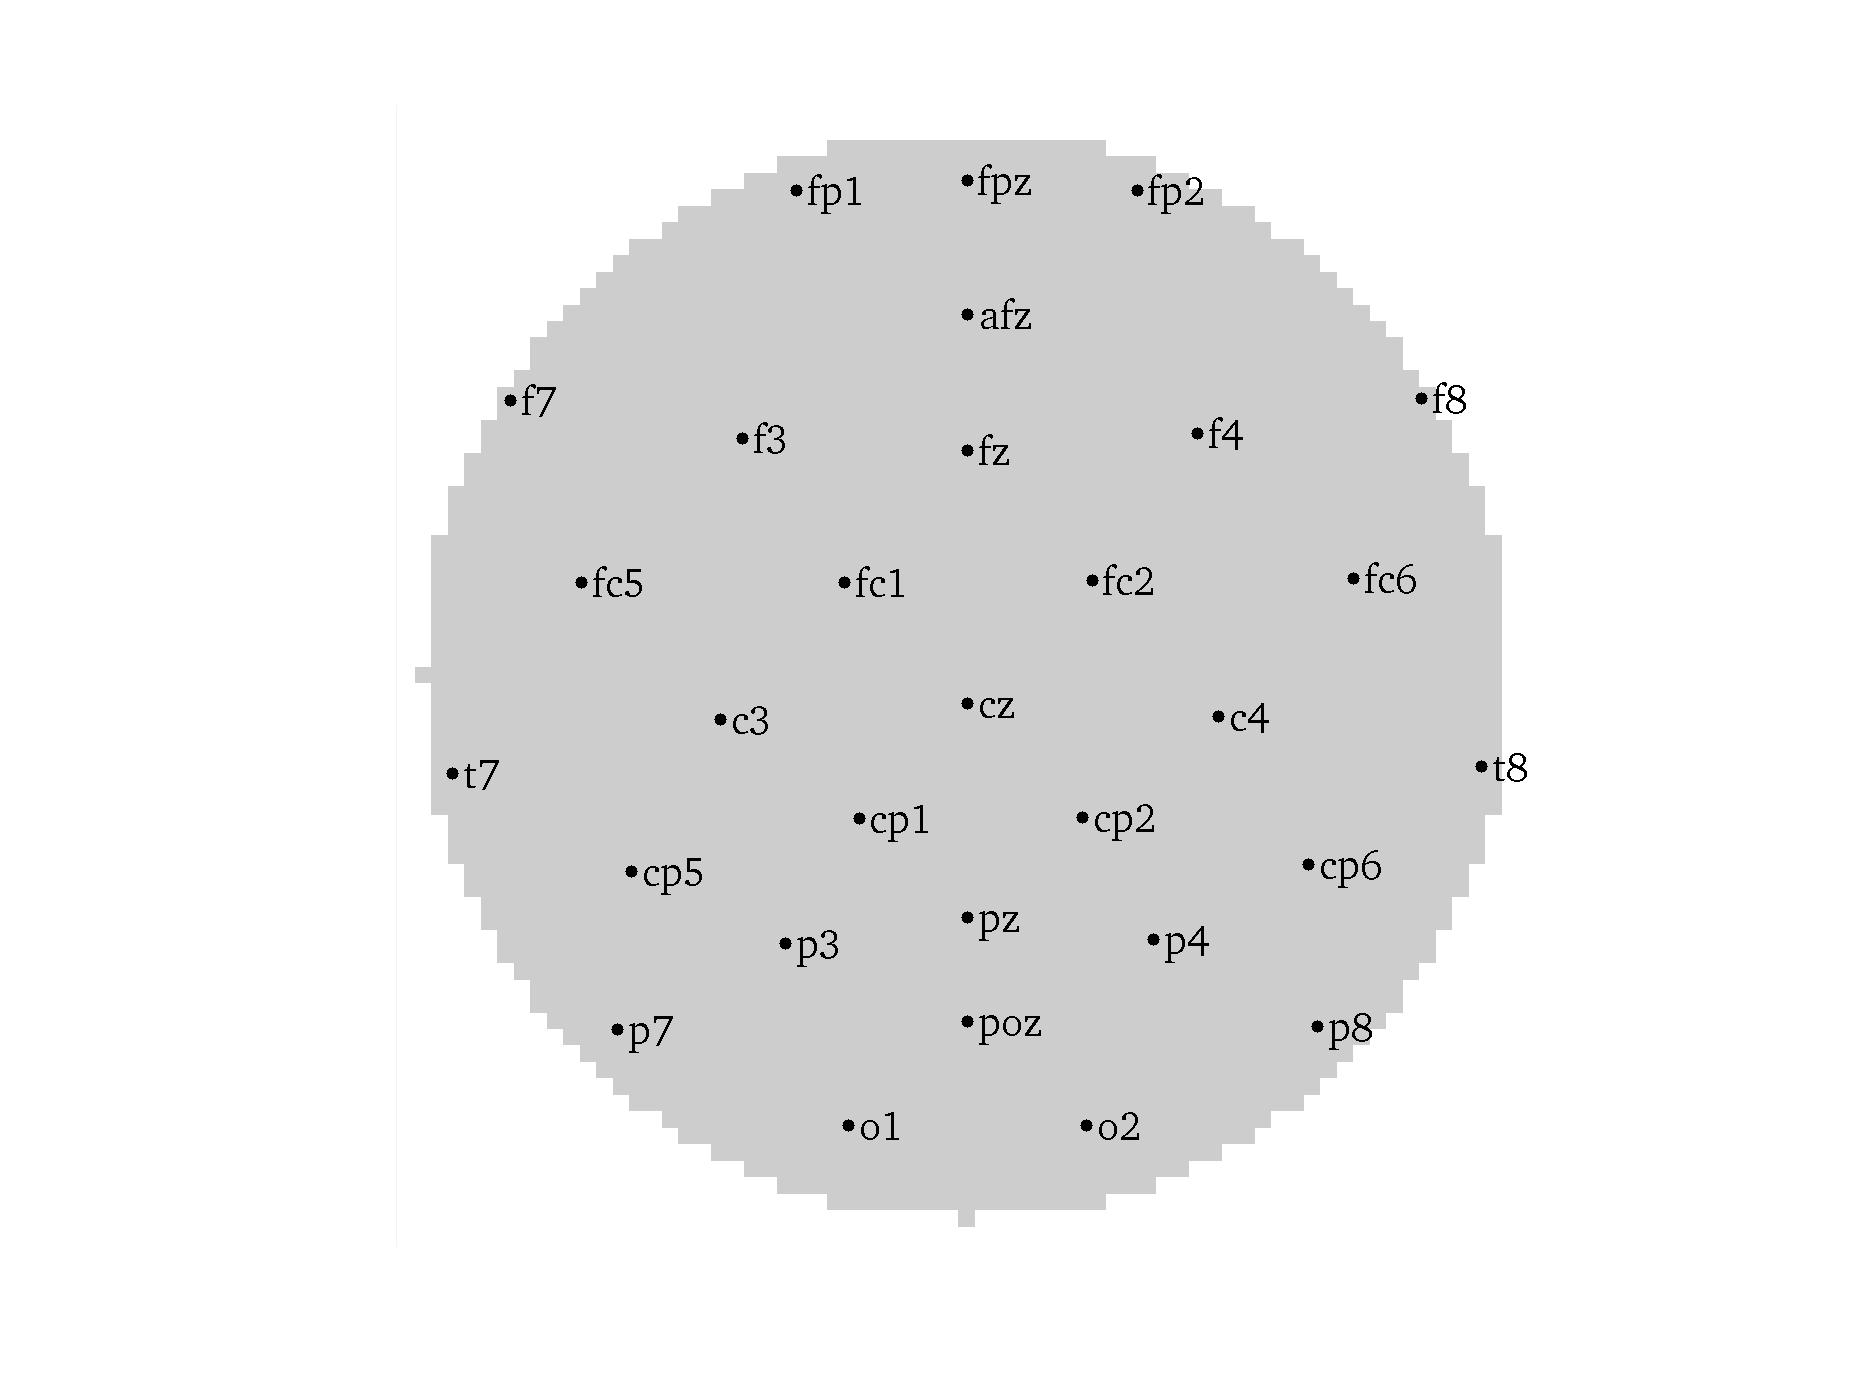

# 6. Obtención de GFP - Tarea 1

Para los cálculos a continuación uso ref https://link.springer.com/content/pdf/10.1007/s10548-008-0054-5.pdf.

Siendo la media $\bar{u}=\frac{1}{c}\sum_{i=1}^{c}{u_{i}}$   donde $c$ es la cantidad total de canales y $u_{i}$ es la medición del i-ésimo canal.

El *average reference* se calcula $v_i=u_i-\bar{u}$ \\
El *Global field power* (GFP) se calcula como 
$GFP(n)=\sqrt{\frac{1}{c}\sum_{i=1}^{c}v_{i}^2}$ (para cada tiempo *t* o muestra *n*).
Los picos de GCP se encuentran con la función find_peaks. Para evitar que estén demasiado próximos entre sí se elige el parámetro distancia.
Por ejemplo eligiendo distance=8 y con la frecuencia de muestreo de 128 Hz los picos deberán estar alejados en no menos de 60 ms (aproximadamente).

Para cada indice identificados del máximo de GCP se calcula cuanto vale $v_{i}$.

Antes distance=8 y prominence=1, si se dejan iguales a 1 y 0 respectivamente coinciden la cantidad de picos con lo obtenido en la función locmax de Frederic (13135).
  

In [16]:
gfp, peaks, v_i_peaks, gfp_values, gfp2, n_gfp = find_gfp_peaks(
    eeg_data   = concat_fields(eegs_resting_state, data_field), 
    prominence = 1, 
    distance   = 1,
    height     = 0
)

show_complete_gfp_peaks_summary(
    gfp, 
    peaks, 
    sfrequency = eegs[0].sfrequency
)

- Cantidad de picos de GFP: 8846
- El intervalo temporal entre máximos de GFP promedio es: 67.83228518937253 ms
- El intervalo temporal entre máximos de GFP más chico es: 23.4375 s
- El intervalo temporal entre máximos de GFP más grande es: 476.5625 ms


In [17]:
data = np.transpose(v_i_peaks)
data.shape

(8846, 30)

In [18]:
df = pd.DataFrame(data, columns=montage.ch_names)

In [19]:
plot_eeg_pca(info_eeg, np.transpose(df))

### Alternativa de Reducción de ruido vía PCA (Tarea 1)

Se calcula la matriz de PCA y se toman pocas componentes, luego se recompone la señal y se compara visualmente con la señal original de los canales.  Esta reducción se puede incluir en la función de búsqueda de GFP.

In [20]:
Xnl,acum=reduce_noise_pca(v_i_peaks,8)

In [21]:
acum

array([0.5090489 , 0.63416391, 0.72416872, 0.79605462, 0.83474424,
       0.86481256, 0.88453117, 0.90182098])

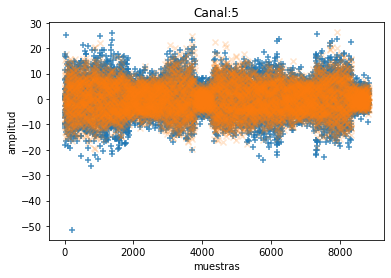

In [22]:
nro_canal=5
plot_sx_reduce_noise(v_i_peaks,Xnl,5)

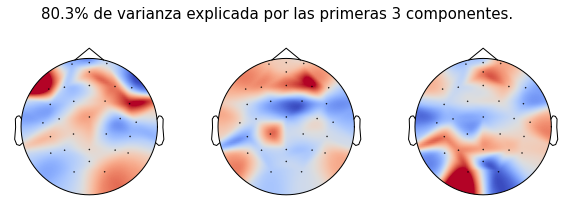

In [23]:
df = pd.DataFrame(Xnl.T, columns=montage.ch_names)
plot_eeg_pca(info_eeg, np.transpose(df))

# 7. Cálculo de *kmeans* modificado - Tarea 2 

Mapas usados en todas las funciones a continuación:

In [24]:
X=v_i_peaks

*kmeans_gfp*

In [25]:
n_clusters = 4
maps_kmeans,labels_gfp,cv = kmeans2(X, gfp , peaks, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

labels_gfp es un vector del mismo largo que gfp con el label del cluster.

maps_kmeans tiene dimensiones de cantidad de clusters por 30 canales

In [26]:
print(maps_kmeans.shape[0])
print(labels_gfp.shape[0])

4
8846


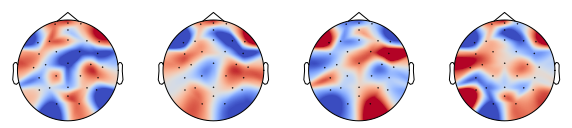

In [27]:
plot_maps_pca(maps_kmeans,n_clusters,info_eeg)

In [28]:
plot_vectores_kmeans(X,labels_gfp,n_clusters)

In [29]:
eeg1 = eegs[1].to_dict()
ch   = eeg1['nchannels']

In [30]:
sil = silhoutte_modificado2(
    maps_kmeans, 
    X,
    labels_gfp, 
    ch,
    n_clusters
)

plot_silhoutte_modificado2(n_clusters, sil, labels_gfp)

For n_clusters = 4 The average silhouette_score is : 0.2670894339704232


In [31]:
calculo_gev(concat_fields(eegs_resting_state, data_field),X.T,30,4,gfp,gfp2)


[+] Global explained variance GEV = 1.160
GEV_0: 1.160
GEV_1: 0.000
GEV_2: 0.000
GEV_3: 0.000


# Cálculo con otros métodos. Tarea 3

### Nuevos modelos

*Kmeans - clásico*

In [32]:
kmeans = KMeans(n_clusters,random_state=0).fit(X.T)
labels_kmeans_clasico=kmeans.labels_

In [33]:
labels_kmeans_clasico.shape[0]

8846

In [34]:
silhouette_avg = silhouette_score(X.T, labels_kmeans_clasico)
silhouette_avg

0.20412526885898857

In [35]:
sample_silhouette_values = silhouette_samples(X.T, labels_kmeans_clasico)
sample_silhouette_values

array([0.04153773, 0.04895198, 0.08867934, ..., 0.30851096, 0.11156421,
       0.07816615])

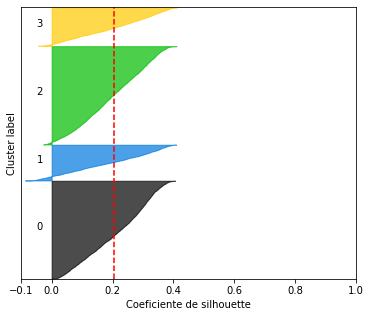

In [36]:
plot_silhoutte(
    df, 
    labels_kmeans_clasico,
    4, 
    sample_silhouette_values,
    silhouette_avg
)

Opción *Jerárquico*

In [37]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(X.T)
z  = linkage(df, method='average', metric='euclidean')

In [38]:
z.shape[0]  #falta 1?

8845

In [39]:
cluster_labels = fcluster(z, .9, criterion='distance')  #dan muchas etiquetas
print(np.unique(cluster_labels))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


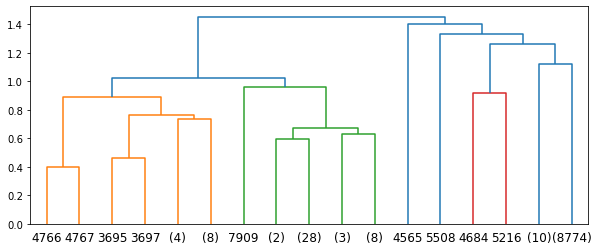

In [40]:
dn = plot_dendrogram(z, 4)

### Evaluación de modelos

In [41]:
# DataFrame with labels
tmp = pd.DataFrame({
    'Labels_kmeans_gfp': labels_gfp, 
    'Labels_kmeans_clasico': labels_kmeans_clasico
})

# crosstab: ct
ct0 = pd.crosstab(tmp['Labels_kmeans_gfp'], tmp['Labels_kmeans_clasico'])
ct0

Labels_kmeans_clasico     0    1     2    3
Labels_kmeans_gfp                          
0                      1239    1  1188    0
1                       344  763   394  829
2                       455  405   528  432
3                      1162    0  1106    0

Criterio VanDongen

In [42]:
van_dongen(ct0)

0.8229581673306773

Rand Score

In [43]:
ari0 = adjusted_rand_score(labels_gfp, labels_kmeans_clasico)
ari0

0.12381671225265949

### Validación Interna
distancias: conceptos de cohesión (cuán cerca están dentro de un cluster) y separación (cuán separados están los clusters)

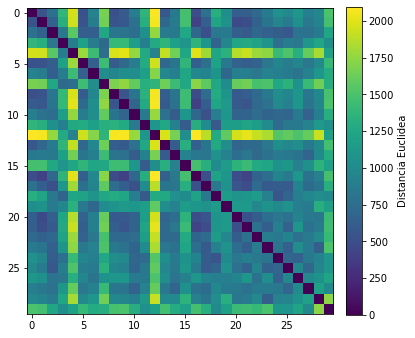

In [44]:
d = euclidean_distances(X, X)
plot_distancia_euclidea(d)